# CM4107 Advanced Artificial Intelligence
## Coursework Part 1 - ANN and kNN Hybrid
## Alistair Quinn 1701183

### Imports 

In [1]:
%matplotlib inline
import numpy as np
import scipy.special 
import matplotlib.pyplot as plt
import pandas as pd
import random
import operator

### Load Train and Test Datasets 

#### For ANN

In [2]:
datasets = {'wine':{},'breast_cancer':{}}
#Dataset 1: Wine
file = open('datasets/wine/wine_train.csv','r')
file.readline()
datasets['wine']['train'] = file.readlines()
file.close()
file = open('datasets/wine/wine_test.csv','r')
file.readline()
datasets['wine']['test'] = file.readlines()
file.close()
#Dataset 2: Breast Cancer
file = open('datasets/breast_cancer/breast_cancer_train.csv','r')
file.readline()
datasets['breast_cancer']['train'] = file.readlines()
file.close()
file = open('datasets/breast_cancer/breast_cancer_train.csv', 'r')
file.readline()
datasets['breast_cancer']['test'] = file.readlines()
file.close()

#### For kNN

In [3]:
#Dataset 1: Wine
wine_train = pd.read_csv('datasets/wine/wine_train.csv')
datasets['wine']['train_x'] = wine_train.iloc[:,1:12]
datasets['wine']['train_y'] = wine_train.iloc[:,0:1]
wine_test = pd.read_csv('datasets/wine/wine_test.csv')
datasets['wine']['test_x'] = wine_test.iloc[:,1:12]
datasets['wine']['test_y'] = wine_test.iloc[:,0:1]
#Dataset 2: Breast Cancer 
breast_cancer_train = pd.read_csv('datasets/breast_cancer/breast_cancer_train.csv')
datasets['breast_cancer']['train_x'] = breast_cancer_train.iloc[:,1:33]
datasets['breast_cancer']['train_y'] = breast_cancer_train.iloc[:,0:1]
breast_cancer_test = pd.read_csv('datasets/breast_cancer/breast_cancer_test.csv')
datasets['breast_cancer']['test_x'] = breast_cancer_test.iloc[:,1:33]
datasets['breast_cancer']['test_y'] = breast_cancer_test.iloc[:,0:1]

### Util Functions

In [4]:
#Finally, we can test to see how many of the test instances we got correct
def accuracy(results):
    correct = 0
    for predict, target in results:
        if predict == target:
            correct += 1
    return (correct/float(len(results))) * 100.0

### Variables

These are the idea values from testing ANN and kNN (ann.ipynb and knn.ipynb)

#### Wine Dataset 

In [5]:
#ANN
datasets['wine']['inputnodes'] = 11
datasets['wine']['hiddennodes'] = 10
datasets['wine']['outputnodes'] = 11
datasets['wine']['epochs'] = 250
datasets['wine']['lr'] = 0.1 #Learning Rate
datasets['wine']['bs'] = 1 #Batch Size
#KNN
datasets['wine']['k'] = 20
datasets['wine']['weighted'] = True

#### Breast Cancer Datset 

In [6]:
#ANN
datasets['breast_cancer']['inputnodes'] = 30
datasets['breast_cancer']['hiddennodes'] = 15
datasets['breast_cancer']['outputnodes'] = 2
datasets['breast_cancer']['epochs'] = 260
datasets['breast_cancer']['lr'] = 1.0 #Learning Rate
datasets['breast_cancer']['bs'] = 1 #Batch Size
#KNN
datasets['breast_cancer']['k'] = 10
datasets['breast_cancer']['weighted'] = True

### Hybrid Class

#### ANN Class

In [7]:
class neuralNetwork:
    """Artificial Neural Network classifier.

    Parameters
    ------------
    lr : float
      Learning rate (between 0.0 and 1.0)
    ep : int
      Number of epochs for training the network towards achieving convergence
    batch_size : int
      Size of the training batch to be used when calculating the gradient descent. 
      batch_size = 0 standard gradient descent
      batch_size > 0 stochastic gradient descent 

    inodes : int
      Number of input nodes which is normally the number of features in an instance.
    hnodes : int
      Number of hidden nodes in the net.
    onodes : int
      Number of output nodes in the net.


    Attributes
    -----------
    wih : 2d-array
      Input2Hidden node weights after fitting 
    who : 2d-array
      Hidden2Output node weights after fitting 
    E : list
      Sum-of-squares error value in each epoch.
      
    Results : list
      Target and predicted class labels for the test data.
      
    Functions
    ---------
    activation_function : float (between 1 and -1)
        implments the sigmoid function which squashes the node input

    """

    def __init__(self, inputnodes=784, hiddennodes=200, outputnodes=10, learningrate=0.1, batch_size=1, epochs=10):
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        
        #link weight matrices, wih (input to hidden) and who (hidden to output)
        #a weight on link from node i to node j is w_ij
        
        
        #Draw random samples from a normal (Gaussian) distribution centered around 0.
        #numpy.random.normal(loc to centre gaussian=0.0, scale=1, size=dimensions of the array we want) 
        #scale is usually set to the standard deviation which is related to the number of incoming links i.e. 
        #1/sqrt(num of incoming inputs). we use pow to raise it to the power of -0.5.
        #We have set 0 as the centre of the guassian dist.
        # size is set to the dimensions of the number of hnodes, inodes and onodes
        self.wih = np.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.who = np.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, self.hnodes))
        
        #set the learning rate
        self.lr = learningrate
        
        #set the batch size
        self.bs = batch_size
        
        #set the number of epochs
        self.ep = epochs
        
        #store errors at each epoch
        self.E= []
        
        #store results from testing the model
        #keep track of the network performance on each test instance
        self.results= []
        
        #define the activation function here
        #specify the sigmoid squashing function. Here expit() provides the sigmoid function.
        #lambda is a short cut function which is executed there and then with no def (i.e. like an anonymous function)
        self.activation_function = lambda x: scipy.special.expit(x)
        
        pass
    
   
    def batch_input(self, input_list):
        """Yield consecutive batches of the specified size from the input list."""
        for i in range(0, len(input_list), self.bs):
            yield input_list[i:i + self.bs]
    
    #train the neural net
    #note the first part is very similar to the query function because they both require the forward pass
    def train(self, train_inputs):
        """Training the neural net. 
           This includes the forward pass ; error computation; 
           backprop of the error ; calculation of gradients and updating the weights.

            Parameters
            ----------
            train_inputs : {array-like}, shape = [n_instances, n_features]
            Training vectors, where n_instances is the number of training instances and
            n_features is the number of features.
            Note this contains all features including the class feature which is in first position
        
            Returns
            -------
            self : object
        """
      
        for e in range(self.ep):
            print("Training epoch#: ", e)
            sum_error = 0.0   
            for batch in self.batch_input(train_inputs):
                #creating variables to store the gradients   
                delta_who = 0
                delta_wih = 0
                
                # iterate through the inputs sent in
                for instance in batch:
                    # split it by the commas
                    all_values = instance.split(',') 
                    # scale and shift the inputs to address the problem of diminishing weights due to multiplying by zero
                    # divide the raw inputs which are in the range 0-255 by 255 will bring them into the range 0-1
                    # multiply by 0.99 to bring them into the range 0.0 - 0.99.
                    # add 0.01 to shift them up to the desired range 0.01 - 1. 
                    inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
                    #create the target output values for each instance so that we can use it with the neural net
                    #note we need 10 nodes where each represents one of the digits
                    targets = np.zeros(self.onodes) + 0.01 #all initialised to 0.01
                    #all_value[0] has the target class label for this instance
                    targets[int(all_values[0])] = 0.99
        
                    #convert  inputs list to 2d array
                    inputs = np.array(inputs,  ndmin=2).T
                    targets = np.array(targets, ndmin=2).T

                    #calculate signals into hidden layer
                    hidden_inputs = np.dot(self.wih, inputs)
                    #calculate the signals emerging from the hidden layer
                    hidden_outputs = self.activation_function(hidden_inputs)

                    #calculate signals into final output layer
                    final_inputs=np.dot(self.who, hidden_outputs)
                    #calculate the signals emerging from final output layer
                    final_outputs = self.activation_function(final_inputs)
        
                    #to calculate the error we need to compute the element wise diff between target and actual
                    output_errors = targets - final_outputs
                    #Next distribute the error to the hidden layer such that hidden layer error
                    #is the output_errors, split by weights, recombined at hidden nodes
                    hidden_errors = np.dot(self.who.T, output_errors)
            
                       
                    ## for each instance accumilate the gradients from each instance
                    ## delta_who are the gradients between hidden and output weights
                    ## delta_wih are the gradients between input and hidden weights
                    delta_who += np.dot((output_errors * final_outputs * (1.0 - final_outputs)), np.transpose(hidden_outputs))
                    delta_wih += np.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), np.transpose(inputs))
                    
                    sum_error += np.dot(output_errors.T, output_errors)#this is the sum of squared error accumilated over each batced instance
                   
                pass #instance
            
                # update the weights by multiplying the gradient with the learning rate
                # note that the deltas are divided by batch size to obtain the average gradient according to the given batch
                # obviously if batch size = 1 then we dont need to bother with an average
                self.who += self.lr * (delta_who / self.bs)
                self.wih += self.lr * (delta_wih / self.bs)
            pass # batch
            self.E.append(np.asfarray(sum_error).flatten())
            print("errors (SSE): ", self.E[-1])
        pass # epoch
    
    #query the neural net
    def query(self, inputs_list):
        #convert inputs_list to a 2d array
        #print(numpy.matrix(inputs_list))
        #inputs_list [[ 1.   0.5 -1.5]]
        inputs = np.array(inputs_list, ndmin=2).T 
        #once converted it appears as follows
        #[[ 1. ]
        # [ 0.5]
        # [-1.5]]
        #print(numpy.matrix(inputs))
        
        #propogate input into hidden layer. This is the start of the forward pass
        hidden_inputs = np.dot(self.wih, inputs)
        
        
        #squash the content in the hidden node using the sigmoid function (value between 1, -1)
        hidden_outputs = self.activation_function(hidden_inputs)
                
        #propagate into output layer and the apply the squashing sigmoid function
        final_inputs = np.dot(self.who, hidden_outputs)
        
        final_outputs = self.activation_function(final_inputs)
        return final_outputs
    
     
    #iterate through all the test data to calculate model accuracy
    def test(self, test_inputs):
        self.results = []
        
        #go through each test instances
        for instance in test_inputs:
            all_values = instance.split(',') # extract the input feature values for the instance
            target_label = int(all_values[0]) # get the target class for the instance
    
            #scale and shift the inputs this is to make sure values dont lead to zero when multiplied with weights
            inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    
            #query the network with test inputs
            #note this returns 10 output values ; of which the index of the highest value
            # is the networks predicted class label
            outputs = self.query(inputs)
    
            #get the index of the highest output node as this corresponds to the predicted class
            predict_label = np.argmax(outputs) #this is the class predicted by the ANN
    
            self.results.append([predict_label, target_label])
            #compute network error
            ##if (predict_label == target_label):
              ##  self.results.append(1)
            ##else: 
             ##   self.results.append(0)
            pass
        pass
        self.results = np.asfarray(self.results) # flatten results to avoid nested arrays

#### kNN Class

In [8]:
def manhattan(instance1, instance2):
        '''
        Calculates manhattan distance between two instances of data
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        distance = 0
        for val1, val2 in zip(instance1, instance2):
            distance += abs(val1 - val2)      
              
        return 1 / (1+ distance)

In [9]:
class kNN:
    """
    Parameters
    X_train, Y_train : list
    these consists of the training set feature values and associated class labels
    k : int
    specify the number of neighbours
    sim : literal
    specify the name of the similarity metric (e.g. manhattan, eucliedean)
    weighted : Boolean
    specify the voting strategy as weighted or not weighted by similarity values
  
    Attributes
    -----------  
    Results : list
      Target and predicted class labels for the test data.    
    """


    def __init__(self, X_train, Y_train, k=3, sim=manhattan, weighted=False):
        self.X_train = X_train
        self.Y_train = Y_train
        
        if k <= len(self.X_train):
            self.k = k # set the k value for neighbourhood size
        else:
            self.k = len(self.X_train) # to ensure the get_neighbours dont crash
    
        self.similarity = sim # specify a sim metric that has been pre-defined e.g. manhattan or euclidean
        
        self.weighted = weighted # boolean to choose between weighted / unweighted majority voting
        
        #store results from testing 
        self.results= []
        
    #With k-NN, we are interested in finding the k number of points with the greatest similarity 
    # to the the query or test instance.
    def get_neighbours(self, test_instance):
        '''
        Locate most similar neighbours 
        X_train will be a containing features (Float) values (i.e. your training data)
        Y_train will be the corresponding class labels for each instance in X_train
        test_instance will be a List of Float values (i.e. a query instance)
        '''
        similarities = [] # collection to store the similarities to be computed

        for train_instance, y in zip(self.X_train, self.Y_train): #for each member of the training set
            sim = self.similarity(test_instance, train_instance) #calculate the similarity to the test instance
            
            similarities.append((y, sim)) #add the actual label of the example and the computed similarity to a collection 
        #print(distances)
        similarities.sort(key = operator.itemgetter(1), reverse = True) #sort the collection by decreasing similarity
        neighbours = [] # holds the k most similar neighbours
        for x in range(self.k): #extract the k top indices of the collection for return
            neighbours.append(similarities[x])

        return neighbours

    # given the neighbours make a prediction
    # the boolean parameter when set to False will use unweighted majority voting; otherwise weighted majority voting
    # weighting can be helpful to break any ties in voting
    def predict(self, neighbours):
        '''
        Summarise a prediction based upon weighted neighbours calculation
        '''
        class_votes = {}
        for x in range(len(neighbours)):
            response = neighbours[x][0]
            #Quick Check So I don't have to mess around changing loaded datasets
            if(not isinstance(response,int)):
                response = response[0]
            if response in class_votes:
                class_votes[response] += (1-self.weighted) + (self.weighted * neighbours[x][1]) #if not weighted simply add 1
                #class_votes[response] += [1, neighbours[x][1]][weighted == True] 
              
            else:
                class_votes[response] = (1-self.weighted) + (self.weighted * neighbours[x][1])
                #class_votes[response] = [1, neighbours[x][1]][weighted == True] 
                
        #print(class_votes)
        sorted_votes = sorted(class_votes, key = lambda k: (class_votes[k], k), reverse = True)
        #print(sorted_votes)
        return sorted_votes[0]
    
    #iterate through all the test data to calculate accuracy
    def test(self, X_test, Y_test):
        self.results = [] # store the predictions returned by kNN

        for test_instance, target_label in zip(X_test, Y_test):
            neighbours = self.get_neighbours(test_instance)
            predict_label = self.predict(neighbours)
            self.results.append([predict_label, target_label])
            #print('> predicted = ', result,', actual = ', test_label)
    

#### ANN-kNN Hybrid Class

In [10]:
class ANNkNNHybrid:
    def __init__(self, inputnodes=784, hiddennodes=200, outputnodes=10, learningrate=0.1, batch_size=1, epochs=10, k=3, sim=manhattan,weighted=False):
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        self.k = k
        self.sim = sim
        self.weighted = weighted
        #link weight matrices, wih (input to hidden) and who (hidden to output)
        #a weight on link from node i to node j is w_ij
        
        
        #Draw random samples from a normal (Gaussian) distribution centered around 0.
        #numpy.random.normal(loc to centre gaussian=0.0, scale=1, size=dimensions of the array we want) 
        #scale is usually set to the standard deviation which is related to the number of incoming links i.e. 
        #1/sqrt(num of incoming inputs). we use pow to raise it to the power of -0.5.
        #We have set 0 as the centre of the guassian dist.
        # size is set to the dimensions of the number of hnodes, inodes and onodes
        self.wih = np.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.who = np.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, self.hnodes))
        
        #set the learning rate
        self.lr = learningrate
        
        #set the batch size
        self.bs = batch_size
        
        #set the number of epochs
        self.ep = epochs
        
        #store errors at each epoch
        self.E= []
        
        #store results from testing the model
        #keep track of the network performance on each test instance
        self.results= []
        
        #define the activation function here
        #specify the sigmoid squashing function. Here expit() provides the sigmoid function.
        #lambda is a short cut function which is executed there and then with no def (i.e. like an anonymous function)
        self.activation_function = lambda x: scipy.special.expit(x)
        
        pass
    
   
    def batch_input(self, input_list):
        """Yield consecutive batches of the specified size from the input list."""
        for i in range(0, len(input_list), self.bs):
            yield input_list[i:i + self.bs]
    
    #train the neural net
    #note the first part is very similar to the query function because they both require the forward pass
    def train(self, train_inputs):
        """Training the neural net. 
           This includes the forward pass ; error computation; 
           backprop of the error ; calculation of gradients and updating the weights.

            Parameters
            ----------
            train_inputs : {array-like}, shape = [n_instances, n_features]
            Training vectors, where n_instances is the number of training instances and
            n_features is the number of features.
            Note this contains all features including the class feature which is in first position
        
            Returns
            -------
            self : object
        """
      
        for e in range(self.ep):
            print("Training epoch#: ", e)
            sum_error = 0.0   
            for batch in self.batch_input(train_inputs):
                #creating variables to store the gradients   
                delta_who = 0
                delta_wih = 0
                
                # iterate through the inputs sent in
                for instance in batch:
                    # split it by the commas
                    all_values = instance.split(',') 
                    # scale and shift the inputs to address the problem of diminishing weights due to multiplying by zero
                    # divide the raw inputs which are in the range 0-255 by 255 will bring them into the range 0-1
                    # multiply by 0.99 to bring them into the range 0.0 - 0.99.
                    # add 0.01 to shift them up to the desired range 0.01 - 1. 
                    inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
                    #create the target output values for each instance so that we can use it with the neural net
                    #note we need 10 nodes where each represents one of the digits
                    targets = np.zeros(self.onodes) + 0.01 #all initialised to 0.01
                    #all_value[0] has the target class label for this instance
                    targets[int(all_values[0])] = 0.99
        
                    #convert  inputs list to 2d array
                    inputs = np.array(inputs,  ndmin=2).T
                    targets = np.array(targets, ndmin=2).T

                    #calculate signals into hidden layer
                    hidden_inputs = np.dot(self.wih, inputs)
                    #calculate the signals emerging from the hidden layer
                    hidden_outputs = self.activation_function(hidden_inputs)

                    #calculate signals into final output layer
                    final_inputs=np.dot(self.who, hidden_outputs)
                    #calculate the signals emerging from final output layer
                    final_outputs = self.activation_function(final_inputs)
        
                    #to calculate the error we need to compute the element wise diff between target and actual
                    output_errors = targets - final_outputs
                    #Next distribute the error to the hidden layer such that hidden layer error
                    #is the output_errors, split by weights, recombined at hidden nodes
                    hidden_errors = np.dot(self.who.T, output_errors)
            
                       
                    ## for each instance accumilate the gradients from each instance
                    ## delta_who are the gradients between hidden and output weights
                    ## delta_wih are the gradients between input and hidden weights
                    delta_who += np.dot((output_errors * final_outputs * (1.0 - final_outputs)), np.transpose(hidden_outputs))
                    delta_wih += np.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), np.transpose(inputs))
                    
                    sum_error += np.dot(output_errors.T, output_errors)#this is the sum of squared error accumilated over each batced instance
                   
                pass #instance
            
                # update the weights by multiplying the gradient with the learning rate
                # note that the deltas are divided by batch size to obtain the average gradient according to the given batch
                # obviously if batch size = 1 then we dont need to bother with an average
                self.who += self.lr * (delta_who / self.bs)
                self.wih += self.lr * (delta_wih / self.bs)
            pass # batch
            self.E.append(np.asfarray(sum_error).flatten())
            print("errors (SSE): ", self.E[-1])
        #Query ANN with Test Inputs Again 
        #go through each test instances
        x_values = []
        y_values = []
        for instance in train_inputs:
            all_values = instance.split(',') # extract the input feature values for the instance
            target_label = int(all_values[0]) # get the target class for the instance
    
            #scale and shift the inputs this is to make sure values dont lead to zero when multiplied with weights
            inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    
            #query the network with test inputs
            #note this returns 10 output values ; of which the index of the highest value
            # is the networks predicted class label
            outputs = self.query_hidden(inputs)
            
            #Add converted instance to array
            x_values.append(outputs)
            
            #Add Corresponding target to other array
            y_values.append(target_label)
        #Create kNN
        self.kNN = kNN(x_values,y_values,self.k,self.sim,self.weighted)
    
    
    #query the neural net
    def query(self, inputs_list):
        #convert inputs_list to a 2d array
        #print(numpy.matrix(inputs_list))
        #inputs_list [[ 1.   0.5 -1.5]]
        inputs = np.array(inputs_list, ndmin=2).T 
        #once converted it appears as follows
        #[[ 1. ]
        # [ 0.5]
        # [-1.5]]
        #print(numpy.matrix(inputs))
        
        #propogate input into hidden layer. This is the start of the forward pass
        hidden_inputs = np.dot(self.wih, inputs)
        
        
        #squash the content in the hidden node using the sigmoid function (value between 1, -1)
        hidden_outputs = self.activation_function(hidden_inputs)
                
        #propagate into output layer and the apply the squashing sigmoid function
        final_inputs = np.dot(self.who, hidden_outputs)
        
        final_outputs = self.activation_function(final_inputs)
        return final_outputs
    
    def query_hidden(self,inputs_list):
        #convert inputs_list to a 2d array
        #print(numpy.matrix(inputs_list))
        #inputs_list [[ 1.   0.5 -1.5]]
        inputs = np.array(inputs_list, ndmin=2).T 
        #once converted it appears as follows
        #[[ 1. ]
        # [ 0.5]
        # [-1.5]]
        #print(numpy.matrix(inputs))
        
        #propogate input into hidden layer. This is the start of the forward pass
        hidden_inputs = np.dot(self.wih, inputs)
        
        
        #squash the content in the hidden node using the sigmoid function (value between 1, -1)
        hidden_outputs = self.activation_function(hidden_inputs)
        return hidden_outputs
     
    #iterate through all the test data to calculate model accuracy
    def test(self, test_inputs):
        self.results = []
        x_values = []
        y_values = []
        #go through each test instances
        for instance in test_inputs:
            all_values = instance.split(',') # extract the input feature values for the instance
            target_label = int(all_values[0]) # get the target class for the instance
    
            #scale and shift the inputs this is to make sure values dont lead to zero when multiplied with weights
            inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    
            #query the network with test inputs
            #note this returns 10 output values ; of which the index of the highest value
            # is the networks predicted class label
            outputs = self.query_hidden(inputs)
    
            #get the index of the highest output node as this corresponds to the predicted class
            predict_label = np.argmax(outputs) #this is the class predicted by the ANN
    
            #Add outputs to x values
            x_values.append(outputs)
            
            #Add target to target list
            y_values.append(target_label)
        #Test knn
        self.kNN.test(x_values,y_values)
        #Set results to kNN results
        self.results = self.kNN.results
        print(self.kNN.results)

### Comparing Results of all 3 Models 

#### Setup

In [11]:
wine_results = []
breast_cancer_results = []

#### ANN

##### Wine Dataset

In [12]:
#Train
ann = neuralNetwork(datasets['wine']['inputnodes'],
                   datasets['wine']['hiddennodes'],
                   datasets['wine']['outputnodes'],
                   datasets['wine']['lr'],
                   datasets['wine']['bs'],
                   datasets['wine']['epochs'])
ann.train(datasets['wine']['train'])
#Test
correct = 0
ann.test(datasets['wine']['test'])
for result in ann.results:
    if (result[0] == result[1]):
        correct += 1
    pass 
correct = 100 * (correct/len(ann.results))
wine_results.append(correct)

Training epoch#:  0
errors (SSE):  [1743.69107385]
Training epoch#:  1
errors (SSE):  [1611.76213807]
Training epoch#:  2
errors (SSE):  [1609.05176636]
Training epoch#:  3
errors (SSE):  [1608.14560802]
Training epoch#:  4
errors (SSE):  [1607.71382762]
Training epoch#:  5
errors (SSE):  [1607.46931658]
Training epoch#:  6
errors (SSE):  [1607.31491648]
Training epoch#:  7
errors (SSE):  [1607.20923596]
Training epoch#:  8
errors (SSE):  [1607.13196724]
Training epoch#:  9
errors (SSE):  [1607.07213619]
Training epoch#:  10
errors (SSE):  [1607.02337202]
Training epoch#:  11
errors (SSE):  [1606.98176128]
Training epoch#:  12
errors (SSE):  [1606.94478456]
Training epoch#:  13
errors (SSE):  [1606.91075221]
Training epoch#:  14
errors (SSE):  [1606.87848803]
Training epoch#:  15
errors (SSE):  [1606.8471435]
Training epoch#:  16
errors (SSE):  [1606.81608453]
Training epoch#:  17
errors (SSE):  [1606.78481998]
Training epoch#:  18
errors (SSE):  [1606.7529552]
Training epoch#:  19
err

errors (SSE):  [1483.89172065]
Training epoch#:  158
errors (SSE):  [1483.36019617]
Training epoch#:  159
errors (SSE):  [1482.83824183]
Training epoch#:  160
errors (SSE):  [1482.32553061]
Training epoch#:  161
errors (SSE):  [1481.82175705]
Training epoch#:  162
errors (SSE):  [1481.32663588]
Training epoch#:  163
errors (SSE):  [1480.83990073]
Training epoch#:  164
errors (SSE):  [1480.36130285]
Training epoch#:  165
errors (SSE):  [1479.89060991]
Training epoch#:  166
errors (SSE):  [1479.42760482]
Training epoch#:  167
errors (SSE):  [1478.97208467]
Training epoch#:  168
errors (SSE):  [1478.52385964]
Training epoch#:  169
errors (SSE):  [1478.08275205]
Training epoch#:  170
errors (SSE):  [1477.64859538]
Training epoch#:  171
errors (SSE):  [1477.22123342]
Training epoch#:  172
errors (SSE):  [1476.80051943]
Training epoch#:  173
errors (SSE):  [1476.38631534]
Training epoch#:  174
errors (SSE):  [1475.97849106]
Training epoch#:  175
errors (SSE):  [1475.57692374]
Training epoch#

##### Breast Cancer Dataset 

In [13]:
#Train
ann = neuralNetwork(datasets['breast_cancer']['inputnodes'],
                   datasets['breast_cancer']['hiddennodes'],
                   datasets['breast_cancer']['outputnodes'],
                   datasets['breast_cancer']['lr'],
                   datasets['breast_cancer']['bs'],
                   datasets['breast_cancer']['epochs'])
ann.train(datasets['breast_cancer']['train'])
#Test
correct = 0
ann.test(datasets['breast_cancer']['test'])
for result in ann.results:
    if (result[0] == result[1]):
        correct += 1
    pass 
correct = 100 * (correct/len(ann.results))
breast_cancer_results.append(correct)

Training epoch#:  0
errors (SSE):  [142.18884967]
Training epoch#:  1
errors (SSE):  [141.22213423]
Training epoch#:  2
errors (SSE):  [140.40052493]
Training epoch#:  3
errors (SSE):  [139.25089155]
Training epoch#:  4
errors (SSE):  [137.54183342]
Training epoch#:  5
errors (SSE):  [134.93280465]
Training epoch#:  6
errors (SSE):  [130.96058675]
Training epoch#:  7
errors (SSE):  [125.09904001]
Training epoch#:  8
errors (SSE):  [116.96956739]
Training epoch#:  9
errors (SSE):  [106.69739367]
Training epoch#:  10
errors (SSE):  [95.13855649]
Training epoch#:  11
errors (SSE):  [83.59155528]
Training epoch#:  12
errors (SSE):  [73.15733092]
Training epoch#:  13
errors (SSE):  [64.36072851]
Training epoch#:  14
errors (SSE):  [57.22052011]
Training epoch#:  15
errors (SSE):  [51.50559941]
Training epoch#:  16
errors (SSE):  [46.93146365]
Training epoch#:  17
errors (SSE):  [43.24444532]
Training epoch#:  18
errors (SSE):  [40.24101907]
Training epoch#:  19
errors (SSE):  [37.76405457]


errors (SSE):  [13.53355809]
Training epoch#:  166
errors (SSE):  [13.54366196]
Training epoch#:  167
errors (SSE):  [13.55355461]
Training epoch#:  168
errors (SSE):  [13.5632335]
Training epoch#:  169
errors (SSE):  [13.57269644]
Training epoch#:  170
errors (SSE):  [13.5819416]
Training epoch#:  171
errors (SSE):  [13.59096749]
Training epoch#:  172
errors (SSE):  [13.59977296]
Training epoch#:  173
errors (SSE):  [13.60835714]
Training epoch#:  174
errors (SSE):  [13.61671948]
Training epoch#:  175
errors (SSE):  [13.6248597]
Training epoch#:  176
errors (SSE):  [13.6327778]
Training epoch#:  177
errors (SSE):  [13.64047402]
Training epoch#:  178
errors (SSE):  [13.64794885]
Training epoch#:  179
errors (SSE):  [13.65520301]
Training epoch#:  180
errors (SSE):  [13.66223742]
Training epoch#:  181
errors (SSE):  [13.66905322]
Training epoch#:  182
errors (SSE):  [13.67565173]
Training epoch#:  183
errors (SSE):  [13.68203447]
Training epoch#:  184
errors (SSE):  [13.68820311]
Traini

#### kNN

##### Setup

In [14]:
is_weighted = [False, True]

##### Wine Dataset 

In [15]:
#Train and Test
knn = kNN(datasets['wine']['train_x'].values,
          datasets['wine']['train_y'].values,
          datasets['wine']['k'],
         weighted=datasets['wine']['weighted'])
knn.test(datasets['wine']['test_x'].values,datasets['wine']['test_y'].values)
wine_results.append(accuracy(knn.results))

##### Breast Cancer Dataset 

In [16]:
#Train and Test
knn = kNN(datasets['breast_cancer']['train_x'].values,
          datasets['breast_cancer']['train_y'].values,
          datasets['breast_cancer']['k'],
         weighted=datasets['breast_cancer']['weighted'])
knn.test(datasets['breast_cancer']['test_x'].values,datasets['breast_cancer']['test_y'].values)
breast_cancer_results.append(accuracy(knn.results))

#### ANN-kNN Hybrid

##### Wine Dataset

In [17]:
hybrid = ANNkNNHybrid(datasets['wine']['inputnodes'],
                   datasets['wine']['hiddennodes'],
                   datasets['wine']['outputnodes'],
                   datasets['wine']['lr'],
                   datasets['wine']['bs'],
                   datasets['wine']['epochs'],
                      datasets['wine']['k'],
         weighted=datasets['wine']['weighted'])
hybrid.train(datasets['wine']['train'])
#Test
hybrid.test(datasets['wine']['test'])
wine_results.append(accuracy(hybrid.results))

Training epoch#:  0
errors (SSE):  [1726.49855323]
Training epoch#:  1
errors (SSE):  [1611.75526924]
Training epoch#:  2
errors (SSE):  [1609.05312021]
Training epoch#:  3
errors (SSE):  [1608.14050778]
Training epoch#:  4
errors (SSE):  [1607.69911051]
Training epoch#:  5
errors (SSE):  [1607.44368899]
Training epoch#:  6
errors (SSE):  [1607.27758919]
Training epoch#:  7
errors (SSE):  [1607.15958132]
Training epoch#:  8
errors (SSE):  [1607.06940106]
Training epoch#:  9
errors (SSE):  [1606.9960674]
Training epoch#:  10
errors (SSE):  [1606.93317753]
Training epoch#:  11
errors (SSE):  [1606.87677164]
Training epoch#:  12
errors (SSE):  [1606.82427454]
Training epoch#:  13
errors (SSE):  [1606.77393397]
Training epoch#:  14
errors (SSE):  [1606.72450536]
Training epoch#:  15
errors (SSE):  [1606.67506666]
Training epoch#:  16
errors (SSE):  [1606.62490529]
Training epoch#:  17
errors (SSE):  [1606.57344656]
Training epoch#:  18
errors (SSE):  [1606.52020717]
Training epoch#:  19
er

errors (SSE):  [1479.0457639]
Training epoch#:  158
errors (SSE):  [1478.5962831]
Training epoch#:  159
errors (SSE):  [1478.1542152]
Training epoch#:  160
errors (SSE):  [1477.7193738]
Training epoch#:  161
errors (SSE):  [1477.29158417]
Training epoch#:  162
errors (SSE):  [1476.87068236]
Training epoch#:  163
errors (SSE):  [1476.45651433]
Training epoch#:  164
errors (SSE):  [1476.04893508]
Training epoch#:  165
errors (SSE):  [1475.64780796]
Training epoch#:  166
errors (SSE):  [1475.25300392]
Training epoch#:  167
errors (SSE):  [1474.86440084]
Training epoch#:  168
errors (SSE):  [1474.48188293]
Training epoch#:  169
errors (SSE):  [1474.10534014]
Training epoch#:  170
errors (SSE):  [1473.73466763]
Training epoch#:  171
errors (SSE):  [1473.36976528]
Training epoch#:  172
errors (SSE):  [1473.01053722]
Training epoch#:  173
errors (SSE):  [1472.65689141]
Training epoch#:  174
errors (SSE):  [1472.30873927]
Training epoch#:  175
errors (SSE):  [1471.96599529]
Training epoch#:  1

##### Breast Cancer Dataset 

In [18]:
hybrid = ANNkNNHybrid(datasets['breast_cancer']['inputnodes'],
                   datasets['breast_cancer']['hiddennodes'],
                   datasets['breast_cancer']['outputnodes'],
                   datasets['breast_cancer']['lr'],
                   datasets['breast_cancer']['bs'],
                   datasets['breast_cancer']['epochs'],
                      datasets['breast_cancer']['k'],
         weighted=datasets['breast_cancer']['weighted'])
hybrid.train(datasets['breast_cancer']['train'])
#Test
hybrid.test(datasets['breast_cancer']['test'])
breast_cancer_results.append(accuracy(hybrid.results))

Training epoch#:  0
errors (SSE):  [142.76446888]
Training epoch#:  1
errors (SSE):  [139.74440685]
Training epoch#:  2
errors (SSE):  [137.25784766]
Training epoch#:  3
errors (SSE):  [133.70721552]
Training epoch#:  4
errors (SSE):  [128.48472543]
Training epoch#:  5
errors (SSE):  [121.02488405]
Training epoch#:  6
errors (SSE):  [111.15011741]
Training epoch#:  7
errors (SSE):  [99.47335606]
Training epoch#:  8
errors (SSE):  [87.32851316]
Training epoch#:  9
errors (SSE):  [76.07617435]
Training epoch#:  10
errors (SSE):  [66.49629164]
Training epoch#:  11
errors (SSE):  [58.72767518]
Training epoch#:  12
errors (SSE):  [52.54783107]
Training epoch#:  13
errors (SSE):  [47.63941219]
Training epoch#:  14
errors (SSE):  [43.71322103]
Training epoch#:  15
errors (SSE):  [40.53804828]
Training epoch#:  16
errors (SSE):  [37.9371242]
Training epoch#:  17
errors (SSE):  [35.77721619]
Training epoch#:  18
errors (SSE):  [33.95822368]
Training epoch#:  19
errors (SSE):  [32.40487929]
Trai

errors (SSE):  [13.65753743]
Training epoch#:  165
errors (SSE):  [13.66910694]
Training epoch#:  166
errors (SSE):  [13.68047542]
Training epoch#:  167
errors (SSE):  [13.69164147]
Training epoch#:  168
errors (SSE):  [13.70260404]
Training epoch#:  169
errors (SSE):  [13.71336233]
Training epoch#:  170
errors (SSE):  [13.72391583]
Training epoch#:  171
errors (SSE):  [13.73426426]
Training epoch#:  172
errors (SSE):  [13.74440762]
Training epoch#:  173
errors (SSE):  [13.75434609]
Training epoch#:  174
errors (SSE):  [13.76408009]
Training epoch#:  175
errors (SSE):  [13.77361024]
Training epoch#:  176
errors (SSE):  [13.78293731]
Training epoch#:  177
errors (SSE):  [13.79206229]
Training epoch#:  178
errors (SSE):  [13.80098628]
Training epoch#:  179
errors (SSE):  [13.80971058]
Training epoch#:  180
errors (SSE):  [13.8182366]
Training epoch#:  181
errors (SSE):  [13.82656586]
Training epoch#:  182
errors (SSE):  [13.83470004]
Training epoch#:  183
errors (SSE):  [13.8426409]
Trai

#### Comparrison 

##### Wine Dataset 

Text(0.5,1,'Model Accuracy Comparison')

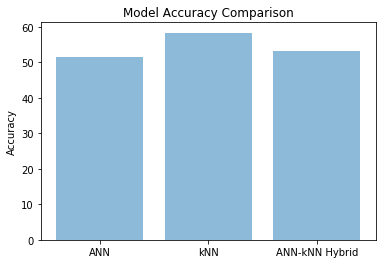

In [19]:
labels = ["ANN", "kNN", "ANN-kNN Hybrid"]
y_pos = np.arange(len(labels))
plt.bar(y_pos,wine_results,align="center",alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')

In [20]:
wine_results

[51.65373621886484, 58.391180073499385, 53.2053899550837]

Based on these results, kNN was most accurate followed by ANN and finally the Hybrid. However the difference in accuracy between the ANN and the Hybrid is very small 

##### Breast Cancer Dataset 

Text(0.5,1,'Model Accuracy Comparison')

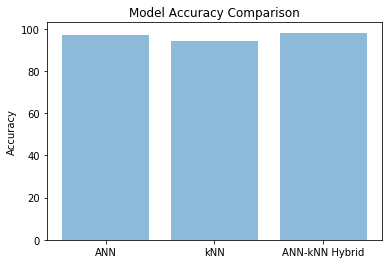

In [21]:
labels = ["ANN", "kNN", "ANN-kNN Hybrid"]
y_pos = np.arange(len(labels))
plt.bar(y_pos,breast_cancer_results,align="center",alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')

In [22]:
breast_cancer_results

[97.1830985915493, 94.38596491228071, 98.23943661971832]

Based on these results, the Hybrid was the most accurate followed by ANN and finally kNN. Again similar to Wine dataset the difference betweeen the ANN and the hybrid accuracies are very small 